In [106]:
import pandas as pd
import numpy as np 
import warnings
warnings.filterwarnings("ignore")
#plt.style.use('fivethirtyeight')
# ML Modelling
from sklearn.tree import export_graphviz, DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score,recall_score, mean_squared_error, classification_report
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, plot_confusion_matrix, classification_report
from sklearn import datasets
from sklearn.metrics import roc_auc_score, roc_curve
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE

import xgboost as xgb
import pickle
import scipy
from sklearn.linear_model import LogisticRegression, LinearRegression
import itertools
# Plotting
import seaborn as sns
from matplotlib.ticker import PercentFormatter
import matplotlib.pyplot as plt
from sklearn.metrics import plot_precision_recall_curve

In [107]:
hypo_data = pd.read_csv('../data/imputed_hypo.csv')
hypo_data = hypo_data.drop(columns = 'Unnamed: 0')

In [32]:
hypo1 = pd.read_csv('../data/hypo_wna.csv')
hypo1 = hypo1.drop(columns = 'Unnamed: 0')

In [33]:
hypo1['class'].unique()

array([0, 1])

In [217]:
hypo_data['TSH'].describe()

count    2690.000000
mean        4.387692
std        18.697671
min       -27.984466
25%         0.500000
50%         1.500000
75%         3.000000
max       478.000000
Name: TSH, dtype: float64

## EDA

* Imbalanced classes 

In [34]:
hypo1['class'].value_counts()

0    2580
1     220
Name: class, dtype: int64

In [35]:
classes = hypo_data['class'].reset_index().drop(columns = 'index')
classes

,class
0,0
1,0
2,0
3,0
4,0
...,...
2685,0
2686,0
2687,0
2688,0


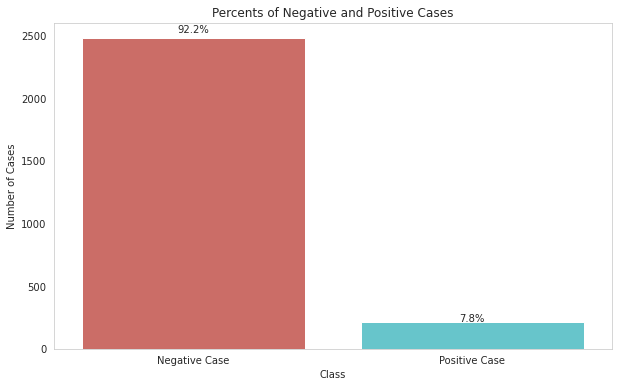

In [36]:
fig, ax = plt.subplots(figsize = (10,6))
sns.countplot(x = 'class', data = hypo_data,palette = 'hls')
#plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
#or p in ax.patches:
    #height = p.get_height()
    #ax.text(p.get_x()+p.get_width()/2.,
           # height + 3,
            #'{:.2%}'.format(height/len(classes)*1),
            #a="center")
            
total = float(len(hypo_data))            
for p in ax.patches:
    percentage = '{:.1f}%'.format(100 * p.get_height()/total)
    
    width = p.get_width()
    height = p.get_height()
    x, y = p.get_xy() 
    ax.annotate(percentage, (x + width/2, y + height*1.02), ha='center')
   
plt.ylabel('Number of Cases')
plt.xlabel('Class')
ax.set_xticklabels(['Negative Case','Positive Case'])
plt.title('Percents of Negative and Positive Cases')
plt.savefig('../data/class-percent.png')


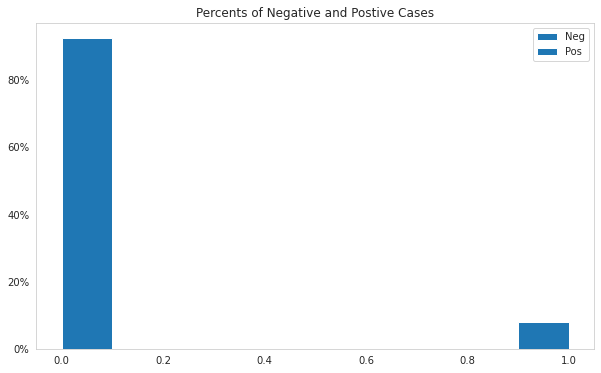

In [37]:
fig, ax = plt.subplots(figsize = (10,6))
plt.hist(classes,weights=np.ones(len(classes)) / len(classes), label = ['neg', 'pos'])
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
plt.title('Percents of Negative and Postive Cases')
plt.legend(['Neg', 'Pos'])

* High THS level indicates hypothyroidism (underactive thyroid) while low THS means hyperthyroidism (overactive thyroid). THS level can inform if your thyroid is making enough hormones or not. 
* If the THS is not normal, you will need other blood test to help find cause of the problem
* Low TT4 level may mean that you have hypothyroidism but this is not the best indicator.Prenancy or taking oral contraceptives might increase this hormones significantly. Severe illness or using corticosteroids might lower your TT4. These conditions and medicines change the amount of proteins in your blood that “bind,” or attach, to T4. Bound T4 is kept in reserve in the blood until it’s need

In [38]:
blood_test = ['age','sex','TSH', 'T3','TT4', 'T4U', 'FTI', 'class']
bt_df = hypo1[blood_test]

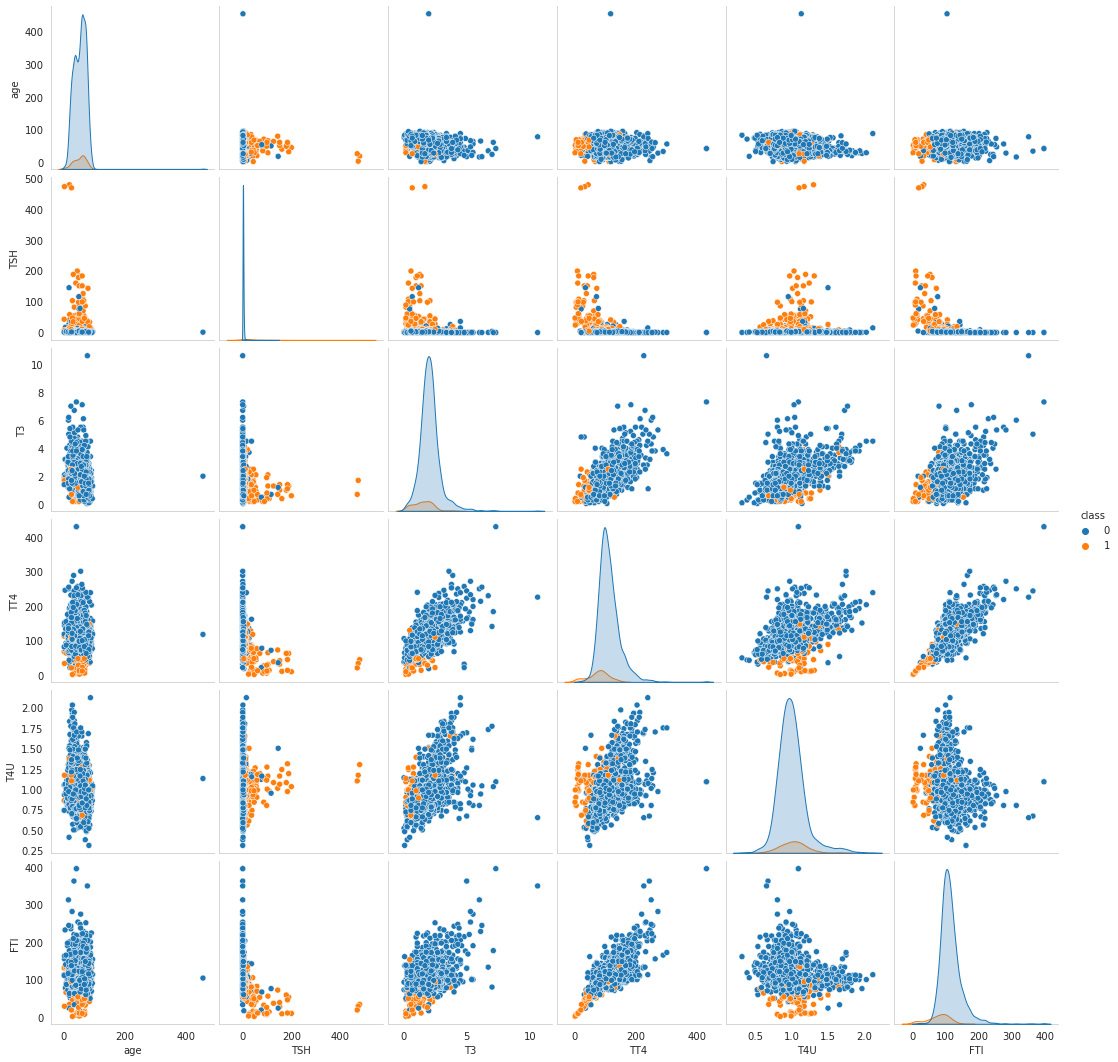

In [39]:
#sns.set_style("whitegrid", {'axes.grid' : False})
mat_plot = sns.pairplot(bt_df, hue="class")
mat_plot.savefig('../graphs/scatterplot-matrix')

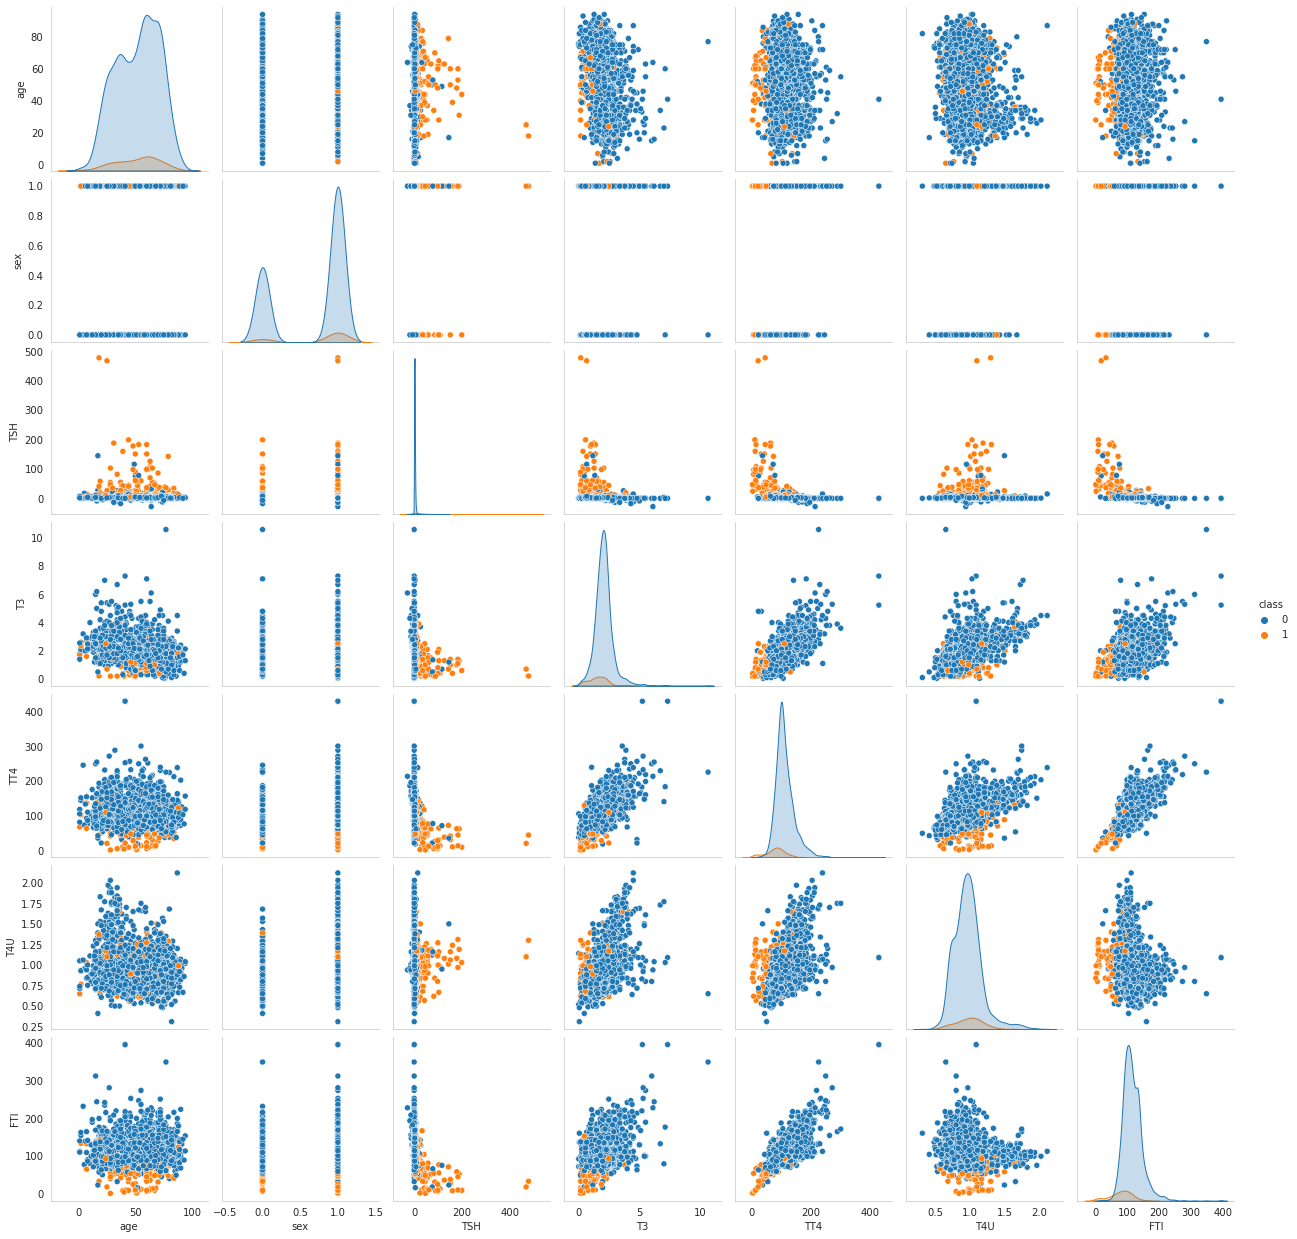

In [40]:
mat_plot = sns.pairplot(hypo_data[blood_test], hue = 'class')

* TSH and TT4 are the most two common thyroid blood tests 

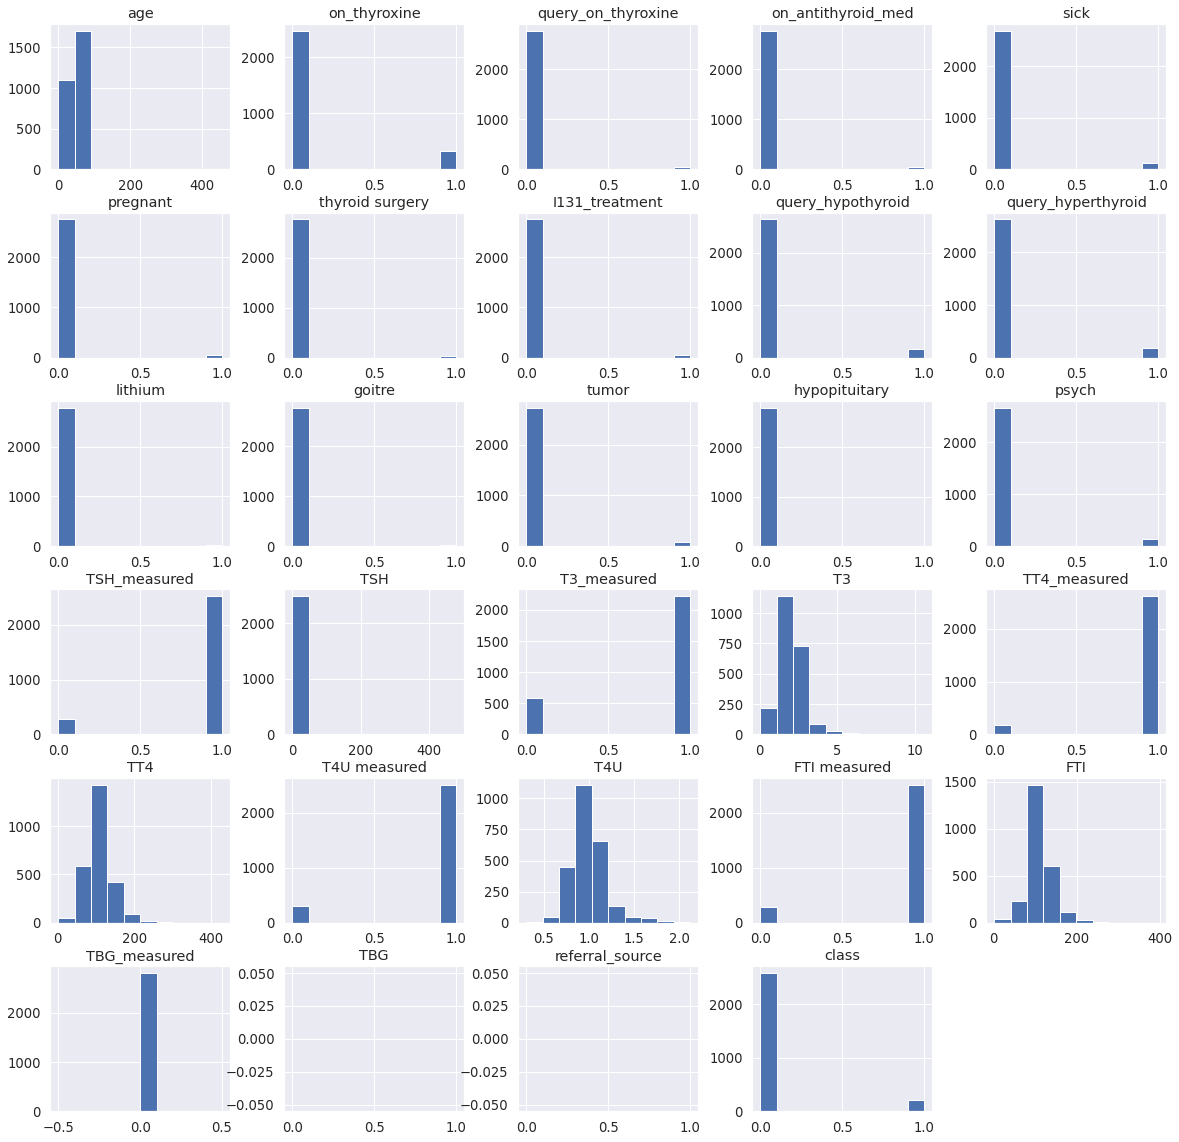

In [391]:
p = hypo1.hist(figsize = (20,20))
plt.savefig('../graphs/hist-matrix.png')

Text(0.5, 0.98, 'TT4 vs TSH between Female and Male')

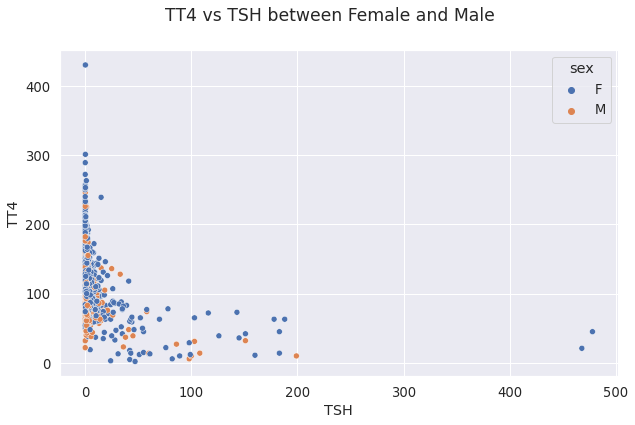

In [392]:
fig, ax = plt.subplots(figsize = (10,6))
sns.scatterplot(data = hypo1, x= 'TSH', y='TT4', hue = 'sex')
fig.suptitle("TT4 vs TSH between Female and Male")

In [1]:
# Plot for prenancy and TT4

In [36]:
#hypo_data[(hypo_data['sex'] != 0) & (hypo_data['sex'] != 1.0)]

In [87]:
classes.unique()

array([0, 1])

## Modelling

#### Random Forest

In [171]:
X = hypo_data.drop(columns = 'class')

In [172]:
y = hypo_data['class']

In [173]:
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=.3,
                                                    random_state=0)

In [174]:
rf = RandomForestClassifier(n_estimators=1000,
                           max_features='auto',
                           random_state=0,
                           oob_score=True)
rf.fit(X_train, y_train)
rf.oob_score_

0.9915029208709506

In [175]:
y_pred_rf = rf.predict(X_test)

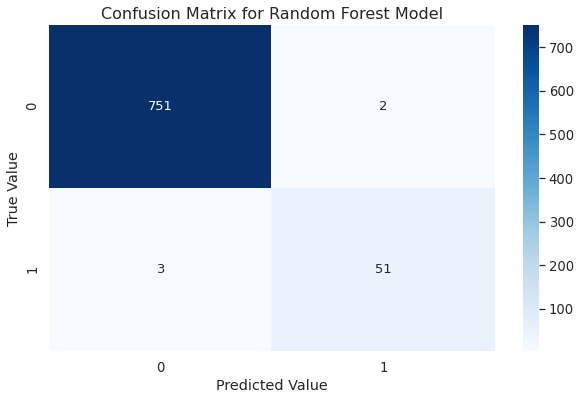

In [176]:
cm = confusion_matrix(y_test, y_pred_rf)
#cmap = sns.diverging_palette(220, 20, as_cmap=True)

fig, ax = plt.subplots(figsize=(10, 6))
sns.heatmap(cm, annot=True, fmt = "g",cmap = "Blues",annot_kws={"size": 13})
sns.set(font_scale=1.2) # for label size
plt.xlabel('Predicted Value')
plt.ylabel('True Value')
plt.title('Confusion Matrix for Random Forest Model', fontsize = 16)
plt.savefig('../graphs/confusion-matrix-randomforest.png')

* True Negative = 842 
* True Positive = 77
* False Negative = 2 
* False Positive = 3


In [177]:
# Compute accuracy, recall, precision
scores = classification_report(y_test, y_pred_rf, target_names=['Negative', 'Positive'])
print("               === Classification Report ===")
print(scores)
print("\n")

               === Classification Report ===
              precision    recall  f1-score   support

    Negative       1.00      1.00      1.00       753
    Positive       0.96      0.94      0.95        54

    accuracy                           0.99       807
   macro avg       0.98      0.97      0.97       807
weighted avg       0.99      0.99      0.99       807





In [178]:
# Compute AUC scores (area under the ROC curve)
cross_val_score = cross_val_score(rf, X, y, cv = 10, scoring = 'roc_auc')
mean_auc_score = cross_val_score.mean()
print("=== Mean AUC Score ===")
print("Mean AUC Score - Random Forest: ", mean_auc_score)

TypeError: 'numpy.ndarray' object is not callable

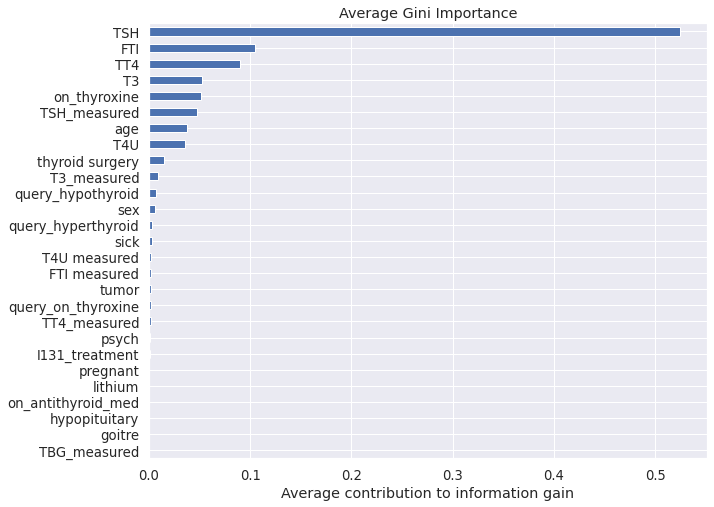

In [179]:
# Plot the feature importance
feat_scores = pd.Series(rf.feature_importances_,
                           index=X.columns)
feat_scores = feat_scores.sort_values()
ax = feat_scores.plot(kind='barh', 
                      figsize=(10,8),
                      color='b')
ax.set_title('Average Gini Importance')
ax.set_xlabel('Average contribution to information gain')
plt.savefig('../graphs/ghini-feature-importance.png')

#### XGBoost 

 * **Oversampling the minority groups to account for the 8%/92% positive/negative ratio**

In [180]:
ros = RandomOverSampler(random_state=0)
X_res, y_res = ros.fit_resample(X_train, y_train)

In [181]:
# create XGBoost classfier model
xgb = xgb.XGBClassifier()

In [182]:
# randomize parameters for parameter tuning 
from sklearn.model_selection import cross_val_score, GridSearchCV, RandomizedSearchCV
from scipy.stats import uniform, randint

params = {"colsample_bytree": uniform(0.9, 0.5),
         "gamma": uniform(0, 0.5),
         "learning_rate": uniform(0.02, 0.2), # default = 0.1 
         "max_depth": randint(2, 5), # default = 3
         "n_estimators": randint(100, 300), # default = 100
         "subsample": uniform(0.9, 0.5),
         "reg_lambda": randint(0,6),
         "min_child_weight" : uniform(1,7)}


In [183]:
# randomized gridsearch
search= RandomizedSearchCV(xgb, param_distributions=params,scoring="neg_log_loss", random_state=0, n_iter=1500, cv=5, verbose=1, n_jobs=-1, return_train_score=True)

In [184]:
# fit to oversampled training set
search.fit(X_res, y_res)

Fitting 5 folds for each of 1500 candidates, totalling 7500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done 2320 tasks      | elapsed:   18.6s
[Parallel(n_jobs=-1)]: Done 4844 tasks      | elapsed:   39.3s
[Parallel(n_jobs=-1)]: Done 7500 out of 7500 | elapsed:  1.2min finished


RandomizedSearchCV(cv=5,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, gamma=None,
                                           gpu_id=None, importance_type='gain',
                                           interaction_constraints=None,
                                           learning_rate=None,
                                           max_delta_step=None, max_depth=None,
                                           min_child_weight=None, missing=nan,
                                           monotone_constraints=None,
                                           n_estimators=100,...
                                        'min_child_weight': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7fd6c51cbd00>,
                                        'n_estima

In [185]:
# predict on testing set 
xgb_pred= search.best_estimator_.predict(X_test)

In [186]:
y_pred_xgb = search.predict(X_test)

In [187]:
#len(y_pred_xgb)
len(xgb_pred)

807

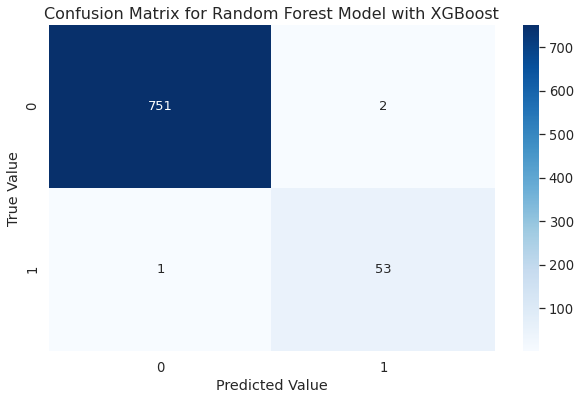

In [212]:
cm = confusion_matrix(y_test, y_pred_xgb)
#cmap = sns.diverging_palette(220, 20, as_cmap=True)

fig, ax = plt.subplots(figsize=(10, 6))
sns.heatmap(cm, annot=True, fmt = "g",cmap = "Blues",annot_kws={"size": 13})
sns.set(font_scale=1.2) # for label size
plt.xlabel('Predicted Value')
plt.ylabel('True Value')
plt.title('Confusion Matrix for Random Forest Model with XGBoost', fontsize = 16)
plt.savefig('../graphs/confusion-matrix-randomforest.png')

In [191]:
print(f'{''}.format(accuracy_score(y_test, xgb_pred))
print(precision_score(y_test, xgb_pred))
print(recall_score(y_test, xgb_pred))
print(confusion_matrix(y_test, xgb_pred))
print(search.best_estimator_)

SyntaxError: EOL while scanning string literal (<ipython-input-191-7a0e1fca8c29>, line 1)

In [192]:
scores_xgb = classification_report(y_test, xgb_pred, target_names=['Negative', 'Positive'])
print("               === Classification Report(XGB) ===")
print(scores_xgb)
print("\n")

               === Classification Report(XGB) ===
              precision    recall  f1-score   support

    Negative       1.00      1.00      1.00       753
    Positive       0.96      0.98      0.97        54

    accuracy                           1.00       807
   macro avg       0.98      0.99      0.99       807
weighted avg       1.00      1.00      1.00       807





In [193]:
pickle.dump(search, open('pickle.xgb', 'wb'))

In [194]:
# double check 
loaded_model = pickle.load(open("pickle.xgb", "rb"))
xgb_pred_ = search.best_estimator_.predict(X_test)
print(accuracy_score(y_test, xgb_pred))

0.9962825278810409


#### Logistic Regression

In [195]:
logreg = LogisticRegression(max_iter=1000)
logreg.fit(X,y)
y_pred_log = logreg.predict(X_test)

In [196]:
print('Accuracy of logistic regression classifier on test set: {:.2f}'
      .format(logreg.score(X_test, y_test)))

Accuracy of logistic regression classifier on test set: 0.96


In [197]:
logreg.coef_

array([[-3.42957336e-03,  1.88745703e-01, -4.32781137e+00,
         3.99814615e-01, -2.95352932e-01,  3.94789808e-01,
        -4.99182616e-01, -3.16054137e+00, -1.46835896e-01,
         2.70675217e-01,  2.81825310e-02,  8.08134469e-02,
        -5.02190487e-01,  3.46997924e-01, -9.32129918e-02,
         8.79580961e-02,  2.97376572e+00,  3.06252039e-01,
        -3.55028899e-01, -3.38979086e-01,  1.72423896e-01,
         4.75404479e-03, -4.85619893e-01, -3.83117116e-01,
        -5.85386776e-01, -2.33514765e-02,  0.00000000e+00]])

In [198]:
prob = logreg.predict_proba(X_test)
prob[1:10]

array([[9.76399971e-01, 2.36000285e-02],
       [9.99719907e-01, 2.80092623e-04],
       [9.96730796e-01, 3.26920434e-03],
       [9.58432946e-01, 4.15670535e-02],
       [9.81672467e-01, 1.83275325e-02],
       [9.95314626e-01, 4.68537394e-03],
       [9.91681386e-01, 8.31861384e-03],
       [9.99800940e-01, 1.99059547e-04],
       [4.33079496e-05, 9.99956692e-01]])

In [199]:
beta_coef = pd.DataFrame(logreg.coef_.reshape(27,1), X.columns, columns = ['coef']).sort_values(by = 'coef', ascending = False)
beta_coef

,coef
TSH_measured,2.973766
query_on_thyroxine,0.399815
sick,0.394790
tumor,0.346998
TSH,0.306252
query_hypothyroid,0.270675
sex,0.188746
TT4_measured,0.172424
psych,0.087958
lithium,0.080813


In [200]:
odds = np.exp(logreg.coef_[0])
odds_df = pd.DataFrame(odds, X.columns, columns = ['coef']).sort_values(by = 'coef', ascending = False)

In [201]:
odds_df

,coef
TSH_measured,19.565459
query_on_thyroxine,1.491548
sick,1.484072
tumor,1.414814
TSH,1.358325
query_hypothyroid,1.310849
sex,1.207734
TT4_measured,1.188181
psych,1.091942
lithium,1.084169


In [202]:
odds_df.T

,TSH_measured,query_on_thyroxine,sick,tumor,TSH,query_hypothyroid,sex,TT4_measured,psych,lithium,...,on_antithyroid_med,T3,T3_measured,T4U,T4U measured,pregnant,goitre,FTI measured,thyroid surgery,on_thyroxine
coef,19.565459,1.491548,1.484072,1.414814,1.358325,1.310849,1.207734,1.188181,1.091942,1.084169,...,0.744269,0.712497,0.701153,0.681733,0.615316,0.607027,0.605204,0.55689,0.042403,0.013196


In [203]:
cm_log = confusion_matrix (y_test, y_pred_log)
cm_log

array([[751,   2],
       [ 28,  26]])

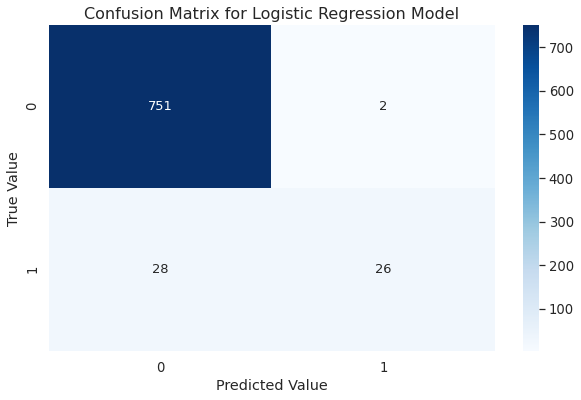

In [86]:
#plot_confusion_matrix(logreg, X_test, y_test, cmap='Blues', ax = ax )
fig, ax = plt.subplots(figsize=(10, 6))
sns.heatmap(cm_log, annot=True, fmt = "g",cmap = "Blues",annot_kws={"size": 13})
sns.set(font_scale=1.2) # for label size
plt.xlabel('Predicted Value')
plt.ylabel('True Value')
plt.title('Confusion Matrix for Logistic Regression Model', fontsize = 16)
plt.savefig('../graphs/confusion-matrix-logistic.png')

In [87]:
cm = confusion_matrix(y_test, y_pred_test)
#cmap = sns.diverging_palette(220, 20, as_cmap=True)

fig, ax = plt.subplots(figsize=(10, 6))
sns.heatmap(cm, annot=True, fmt = "g",cmap = "Blues",annot_kws={"size": 13})
sns.set(font_scale=1.2) # for label size
plt.xlabel('Predicted Value')
plt.ylabel('True Value')
plt.title('Confusion Matrix for Random Forest Model', fontsize = 16)
plt.savefig('../graphs/confusion-matrix-randomforest.png')

NameError: name 'y_pred_test' is not defined

In [205]:
# create synthetic samples from the minor class
os = SMOTE(random_state=0)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
columns = X_train.columns
X_os, y_os = os.fit_sample(X_train, y_train)
#X_os_df = pd.DataFrame(data=X_os,columns=columns )
#y_os_df = pd.DataFrame(data=y_os,columns=['y'])
# we can Check the numbers of our data
print("length of oversampled data is ",len(X_os))
print("number of negative case in oversampled data",len(y_os == 0))
print("Proportion of no subscription data in oversampled data is ",len(y_os==0)/len(X_os))


length of oversampled data is  3452
number of negative case in oversampled data 3452
Proportion of no subscription data in oversampled data is  1.0


In [206]:
log_os = LogisticRegression(max_iter=10000)
log_os.fit(X_os,y_os)
y_pred_log_os = log_os.predict(X_test)

In [207]:
scores = classification_report(y_test, y_pred_log_os, target_names=['Negative', 'Positive'])
print("               === Classification Report ===")
print(scores)
print("\n")

               === Classification Report ===
              precision    recall  f1-score   support

    Negative       1.00      0.98      0.99       753
    Positive       0.75      0.98      0.85        54

    accuracy                           0.98       807
   macro avg       0.87      0.98      0.92       807
weighted avg       0.98      0.98      0.98       807





In [147]:
log_os.coef_

array([[-1.21226741e-03,  6.00091961e-02, -5.20484170e+00,
         2.68787388e-01, -8.46896759e-01,  2.69822048e-01,
        -4.35386466e-01, -4.73334087e+00, -6.23690057e-01,
         1.67887006e-01,  2.57681913e-02, -1.12605901e-01,
        -3.40511885e-01,  3.43097622e-01, -1.08893861e-01,
         4.52460749e-03,  4.72717494e+00,  6.53043486e-01,
        -2.40111639e-01, -3.18064501e-01,  6.46085605e-02,
         4.61642097e-03, -3.58144317e-01, -9.12948883e-01,
        -5.04572405e-01, -2.39001071e-02,  0.00000000e+00]])

In [149]:
odds_ = np.exp(log_os.coef_[0])
pd.DataFrame(odds_, X.columns, columns = ['coef']).sort_values(by = 'coef', ascending = False)

,coef
TSH_measured,112.975947
TSH,1.921380
tumor,1.409306
sick,1.309731
query_on_thyroxine,1.308377
query_hypothyroid,1.182803
TT4_measured,1.066741
sex,1.061846
query_hyperthyroid,1.026103
TT4,1.004627


In [208]:
cm_log_os = confusion_matrix (y_test, y_pred_log_os)
cm_log_os

array([[735,  18],
       [  1,  53]])

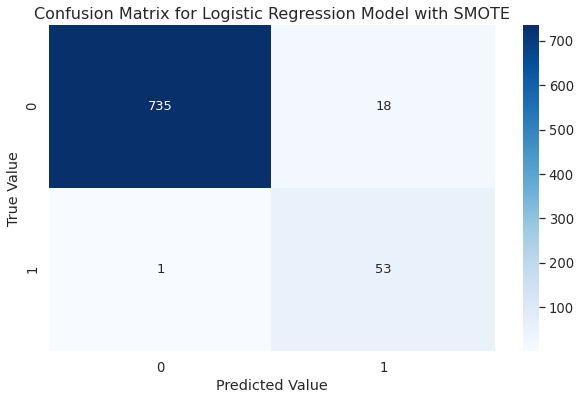

In [209]:
fig, ax = plt.subplots(figsize=(10, 6))
sns.heatmap(cm_log_os, annot=True, fmt = "g",cmap = "Blues",annot_kws={"size": 13})
sns.set(font_scale=1.2) # for label size
plt.xlabel('Predicted Value')
plt.ylabel('True Value')
plt.title('Confusion Matrix for Logistic Regression Model with SMOTE', fontsize = 16)
plt.savefig('../graphs/confusion-matrix-logistic-smote.png')

In [92]:
y.sum() #count positive case

211

In [93]:
y_os.sum()

1726

In [94]:
len(X)

2690

In [95]:
len(X_os)

3452

### Plotting ROC Curve? P recision-Recall Curves

* Roc Curve

In [96]:
# Error message if ran twice?
# ValueError: Found input variables with inconsistent numbers of samples: [840, 924]


In [161]:
def plot_roc(model_lst,X_test,y_test):
    guess = [0 for _ in range(len(y_test))]
    fpr_guess, tpr_guess, threshold_guess = roc_curve(y_test, guess)
    plt.plot(fpr_guess,tpr_guess,label = "Random Classifer")
    for model in model_lst:
        proba = model.predict_proba(X_test)[::,1]
        fpr,tpr,thres = roc_curve(y_test,proba)
        auc = roc_auc_score(y_test, proba) 
        plt.plot(fpr,tpr,label = model)
        # calculate the g-mean for each threshold
        gmeans = np.sqrt(tpr * (1-fpr))
        # locate the index of the largest g-mean
        ix = np.argmax(gmeans)i a
        print('Best Threshold=%f, G-Mean=%.3f' % (thres[ix], gmeans[ix]))
        # plot the roc curve for the model
        plt.scatter(fpr[ix], tpr[ix], marker='o', color='black', label='Best')
        #print (auc)

Best Threshold=0.494435, G-Mean=0.988
Best Threshold=0.248623, G-Mean=0.996


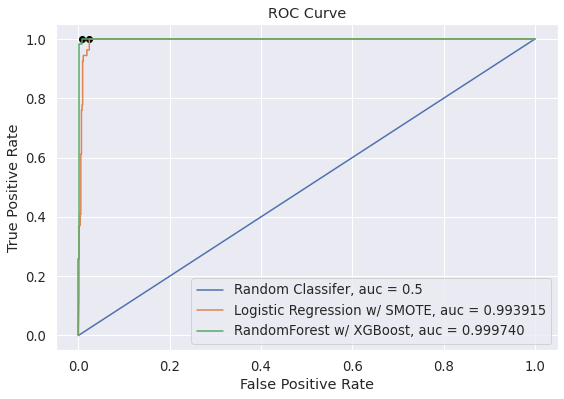

In [162]:
model_lst = [log_os,search]
fig, ax = plt.subplots(figsize = (9,6))
plot_roc(model_lst,X_test,y_test)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(['Random Classifer, auc = 0.5', 'Logistic Regression w/ SMOTE, auc = 0.993915', 'RandomForest w/ XGBoost, auc = 0.999740'])
plt.savefig('../graphs/roc_curve.png')


In [163]:
# figure there is an easy way to do this
from sklearn.metrics import plot_roc_curve
def plot_roc_curve(model_lst,X_test,y_test):
    for model in model_lst:
        #proba = model.predict_proba(X_test)[::,1]
        #fpr,tpr,thres = roc_curve(y_test,proba)
        plot_roc_curve(model, X_test, y_test)

In [164]:
model_lst = [log_os,search]
plot_roc_curve(model_lst,X_test,y_test)

TypeError: 'LogisticRegression' object is not iterable

In [165]:
# ROC random guess
guess = [0 for _ in range(len(y_test))]
fpr_guess, tpr_guess, threshold_guess = roc_curve(y_test, guess)

# ROC Logistic Regression with SMOTE
fpr_os, tpr_os, thresholds_os = roc_curve(y_test, y_pred_log_os)

#ROC Random Forest with XGBoost
fpr_xgb, tpr_xgb, thresholds_xgb = roc_curve(y_test, y_pred_xgb)

# calculate AUC
auc_os = roc_auc_score(y_test, y_pred_log_os)
auc_xgb = roc_auc_score(y_test,y_pred_xgb)

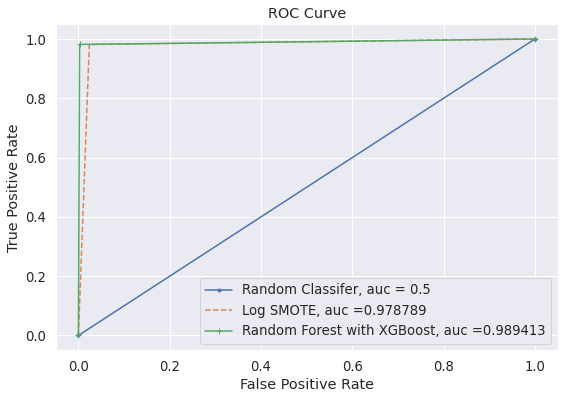

In [166]:
fig, ax = plt.subplots(figsize = (9,6))
plt.plot(fpr_guess, tpr_guess, marker = '.',label = 'Random Classifer, auc = ' + str(0.500000))
plt.plot(fpr_os, tpr_os, linestyle = '--', label = 'Log SMOTE, auc =' + str("{0:.6g}".format(auc_os)))
plt.plot(fpr_xgb, tpr_xgb, marker = '+',label = 'Random Forest with XGBoost, auc =' + str("{0:.6g}".format(auc_xgb)))
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()

* Precision-Recall Curve


In [167]:
from sklearn.metrics import precision_recall_curve
precision_os, recall_os, thres_os = precision_recall_curve(y_test, y_pred_log_os)

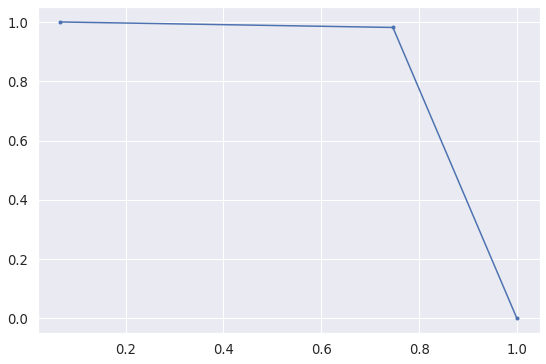

In [168]:
fig, ax = plt.subplots(figsize = (9,6))
plt.plot(precision_os,recall_os, marker = '.',label = 'Log SMOTE')

In [169]:
from sklearn.metrics import auc
#import argmax
def plot_prec_rec(model_lst,X_test,y_test):
    no_skill = len(y_test[y_test==1]) / len(y_test)
    plt.plot([0, 1], [no_skill, no_skill], linestyle='--', label = "Random Classifer")
    for model in model_lst:
        proba = model.predict_proba(X_test)[:,1]
        precision, recall, thres_ = precision_recall_curve(y_test,proba)
        auc_ = auc(recall, precision) 
        plt.plot(recall,precision,label = model)
        fscore = (2 * precision * recall) / (precision + recall)
        # locate the index of the largest f score
        ix = np.argmax(fscore)
        print('Best Threshold=%f, F-Score=%.3f' % (thres_[ix], fscore[ix]))
        # plot the roc curve for the model
    #no_skill = len(testy[testy==1]) / len(testy)
    #pyplot.plot([0,1], [no_skill,no_skill], linestyle='--', label='No Skill')
    #pyplot.plot(recall, precision, marker='.', label='Logistic')
        plt.scatter(recall[ix], precision[ix], marker='X', color='black', label='Best')
        #print (auc_)

Best Threshold=0.671452, F-Score=0.903
Best Threshold=0.972663, F-Score=0.981


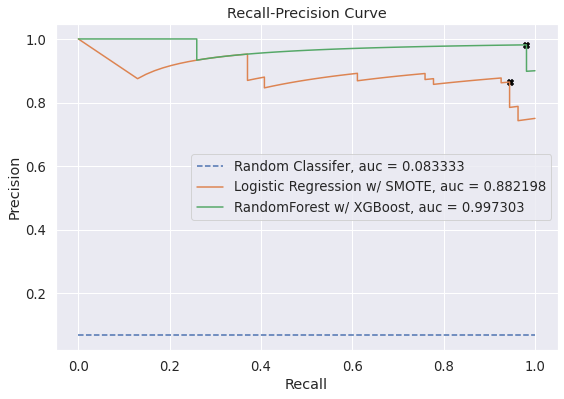

In [170]:
model_lst = [log_os,search]
fig, ax = plt.subplots(figsize = (9,6))
plot_prec_rec(model_lst,X_test,y_test)

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Recall-Precision Curve')
plt.legend(['Random Classifer, auc = 0.083333', 'Logistic Regression w/ SMOTE, auc = 0.882198', 'RandomForest w/ XGBoost, auc = 0.997303'], loc = "center right")
plt.savefig('../graphs/prec-recall-curve.png')

In [ ]:
from sklearn.metrics import plot_precision_recall_curve
#disp = plot_precision_recall_curve(log_os, X_test, y_test)
disp = plot_precision_recall_curve(search, X_test, y_test)
#disp.ax_.set_title('2-class Precision-Recall curve: '
 #                  'AP={0:0.2f}'.format(average_precision))

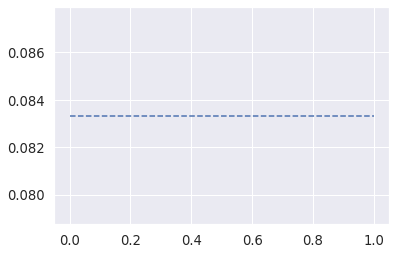

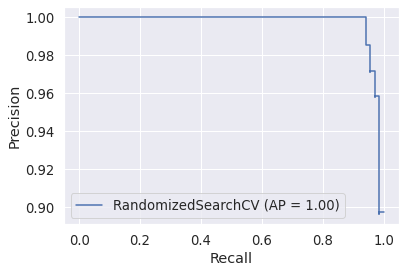

In [363]:
no_skill = len(y_test[y_test==1]) / len(y_test)
plt.plot([0, 1], [no_skill, no_skill], linestyle='--', label = "Random Classifer")
plot_precision_recall_curve(search, X_test, y_test)

* Not sure why the built in method is not working

### Another way to build a logistic regression model

In [76]:
import statsmodels.api as sm
logit_model=sm.Logit(y,X)
result=logit_model.fit(maxiter = 35)
print(result.summary2())

         Current function value: inf
         Iterations: 35


/home/chloe/anaconda3/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:1799: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/chloe/anaconda3/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:1852: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


LinAlgError: Singular matrix

## Extra

Text(0.5, 1.0, 'Heat map (correlations) between features.')

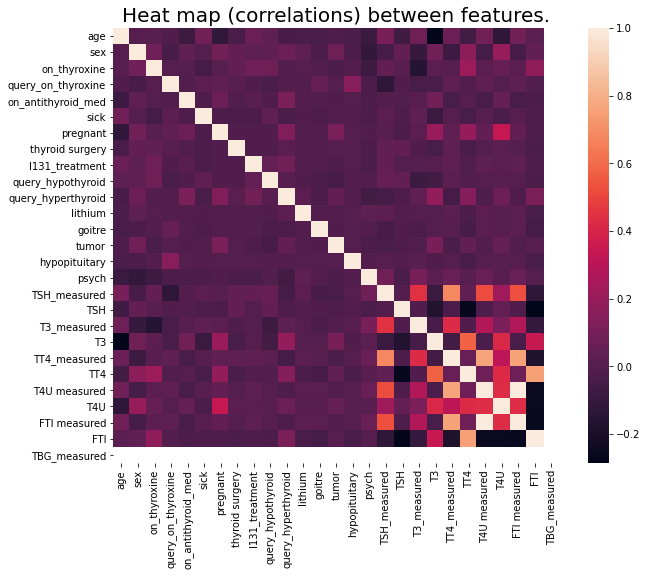

In [25]:
# Plot heatmap 
fig, ax = plt.subplots(figsize=(10,8))
corr = hypo_data.corr()
#cmap = sns.cubehelix_palette(as_cmap=True, dark=0, light=1, reverse=False)
sns.heatmap(corr)
ax.set_title('Heat map (correlations) between features.', fontsize=20)

In [ ]:
sklearn.metrics.confusion_matrix